<a href="https://colab.research.google.com/github/adalbertii/Modele-klasyfikacyjne/blob/main/keras_classification_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Klasyfikacja binarna**

Oparta na modelu neuronowym



Step 1 - Loading the Required Libraries and Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

**Pobranie danych i ich uproszczona analiza**

In [3]:
# zamontować dysk Google
df = pd.read_csv('/content/drive/MyDrive/dane/diabetes.csv')
print(df.shape)

(768, 9)


In [70]:

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.259091,0.617284,1
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.145041,0.382716,0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.277686,0.395062,1
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.069008,0.259259,0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.945455,0.407407,1


In [ ]:
# analiza statystyczna zbioru danych
df.describe()

In [71]:
# sprawdzamy korelacje zmiennych
df.corr()['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

                                  Matryca korelacji zmiennych                                   


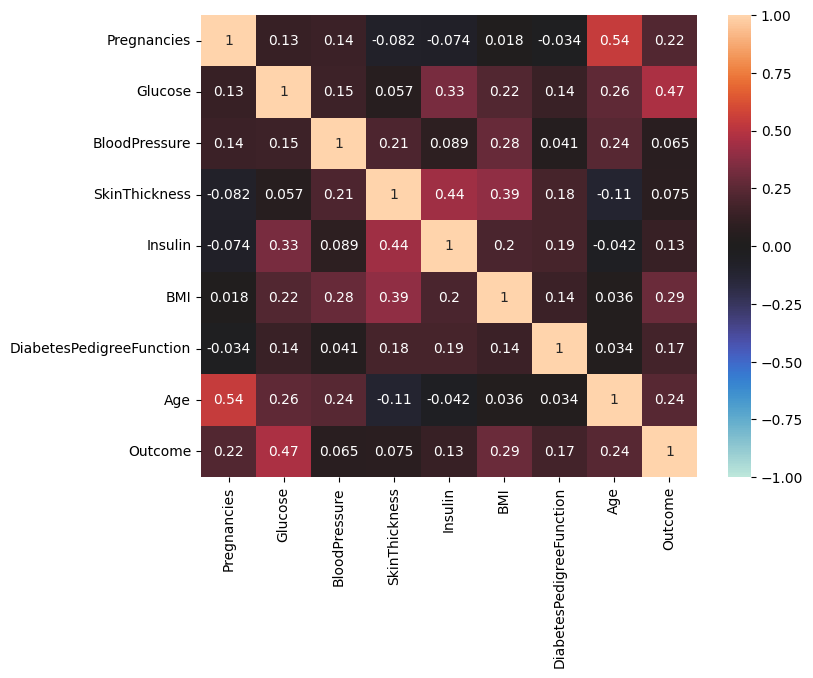

In [76]:
#Sprawdzenie korelacji

print('\033[1mMatryca korelacji zmiennych'.center(100))
plt.figure(figsize=[8,6])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

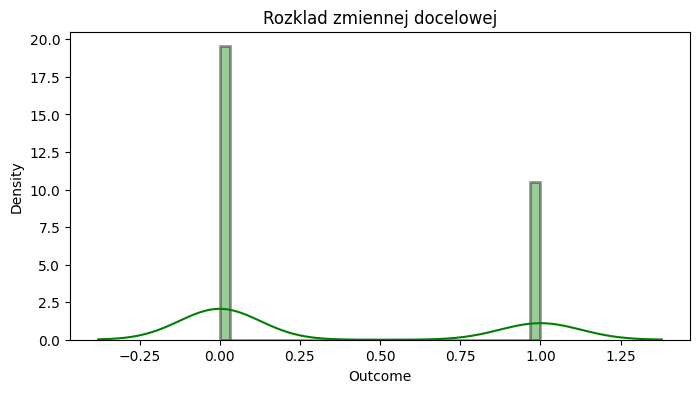

In [74]:
import warnings
warnings.filterwarnings('ignore')
#sprawdzamy rozkład zmiennej objaśnianej
plt.figure(figsize=[8,4])
sns.distplot(df['Outcome'], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Rozklad zmiennej docelowej')
plt.show()

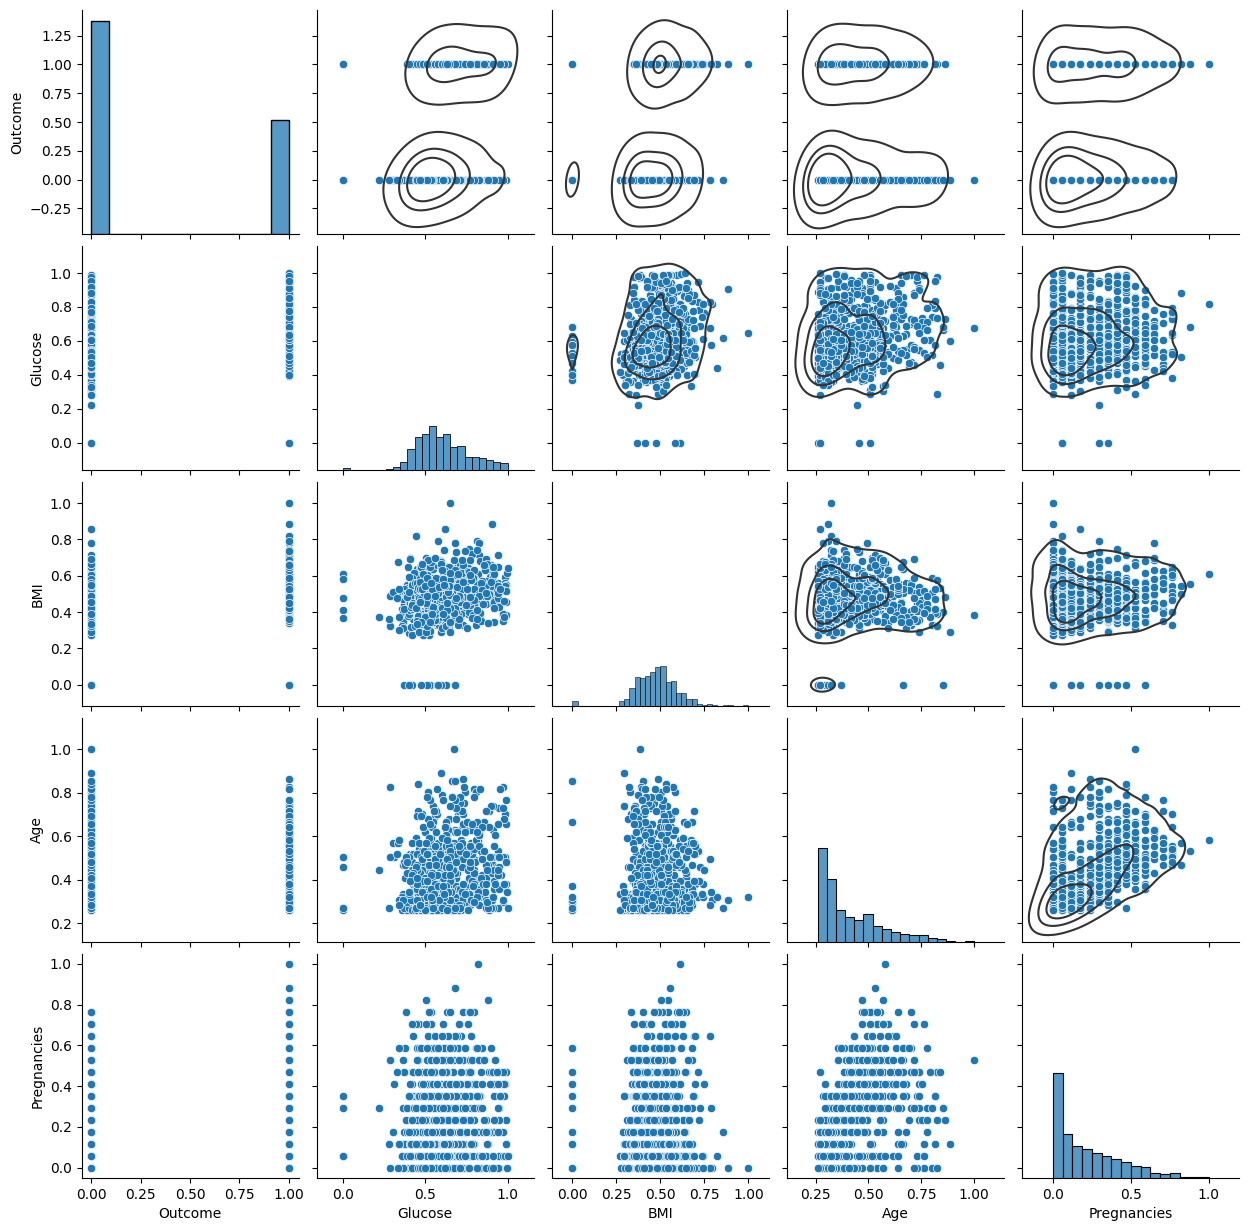

In [18]:
#weryfikacja zależności pomiedzy zmienymi

g = sns.pairplot(df[['Outcome', 'Glucose', 'BMI', 'Age','Pregnancies']])
#plt.title('Wykresy par dla wszystkich zmiennych')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

Step 3 - Creating Arrays for the Features and the Response Variable.

In [9]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
target_column = ['Outcome']
predictors = list(set(list(df.columns))-set(target_column))
predictors

['Age',
 'Insulin',
 'Pregnancies',
 'DiabetesPedigreeFunction',
 'SkinThickness',
 'BloodPressure',
 'BMI',
 'Glucose']

In [5]:
# uproszczone skalowanie wartości
df[predictors] = df[predictors]/df[predictors].max()
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.607510,0.566438,0.207439,0.094326,0.476790,0.194990,0.410381,0.348958
std,0.198210,0.160666,0.158654,0.161134,0.136222,0.117499,0.136913,0.145188,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032231,0.259259,0.000000
25%,0.058824,0.497487,0.508197,0.000000,0.000000,0.406855,0.100723,0.296296,0.000000
50%,0.176471,0.587940,0.590164,0.232323,0.036052,0.476900,0.153926,0.358025,0.000000
75%,0.352941,0.704774,0.655738,0.323232,0.150414,0.545455,0.258781,0.506173,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# tworzy tablice np.array
X = df[predictors].values
y = df[target_column].values

In [14]:
X.shape

(768, 8)

In [15]:
y.shape

(768, 1)

In [7]:
# podzial zbioru na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print('X_train:', X_train.shape); print('X_test:', X_test.shape);print('y_train:', y_train.shape);print('Y_test:',y_test.shape)

X_train: (537, 8)
X_test: (231, 8)
y_train: (537, 1)
Y_test: (231, 1)


In [8]:
#Ponieważ nasza zmienna docelowa reprezentuje kategorię binarną, która została zakodowana jako liczby 0 i 1,
#będziemy musieli ją zakodować.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

count_classes = y_test.shape[1]
print('Liczba klas:', count_classes)

Liczba klas: 2


In [21]:
y_train[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [22]:
print(y_train.shape)
y_train

(537, 2)


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

**Definicja, kompilacja i uczenie modelu neuronowego**

In [23]:
X_train.shape

(537, 8)

In [9]:
#definicja modelu
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=8)) # objaśnić input_dim
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))# objaśnić funkcje aktywacji softmax


# Podczas pracy nad problemem uczenia maszynowego lub głębokiego uczenia,
# funkcje strat/kosztów są wykorzystywane do optymalizacji modelu podczas szkolenia.
# Celem jest prawie zawsze zminimalizowanie funkcji strat.
# Im niższa strata, tym lepszy model. Cross-Entropy loss jest najważniejszą funkcją kosztu.
# Służy ona do optymalizacji modeli klasyfikacyjnych.

In [10]:
# kompilacja modelu
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               4500      
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 59752 (233.41 KB)
Trainable params: 59752 (233.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# uczenie modelu
model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
17/17 [==============================] - 1s 2ms/step - loss: 0.6622 - accuracy: 0.6350
Epoch 2/20
17/17 [==============================] - 0s 2ms/step - loss: 0.6322 - accuracy: 0.6667
Epoch 3/20
17/17 [==============================] - 0s 2ms/step - loss: 0.6028 - accuracy: 0.6909
Epoch 4/20
17/17 [==============================] - 0s 2ms/step - loss: 0.5852 - accuracy: 0.7151
Epoch 5/20
17/17 [==============================] - 0s 2ms/step - loss: 0.5616 - accuracy: 0.7505
Epoch 6/20
17/17 [==============================] - 0s 2ms/step - loss: 0.5294 - accuracy: 0.7467
Epoch 7/20
17/17 [==============================] - 0s 2ms/step - loss: 0.5116 - accuracy: 0.7561
Epoch 8/20
17/17 [==============================] - 0s 2ms/step - loss: 0.4933 - accuracy: 0.7654
Epoch 9/20
17/17 [==============================] - 0s 2ms/step - loss: 0.4895 - accuracy: 0.7616
Epoch 10/20
17/17 [==============================] - 0s 2ms/step - loss: 0.4816 - accuracy: 0.7952
Epoch 11/20
17/17 [

**Ewaluacja modelu**

In [12]:
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))

pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))

17/17 [==============================] - 0s 1ms/step
Accuracy on training data: 0.7914338707923889% 
 Error on training data: 0.20856612920761108
8/8 [==============================] - 0s 2ms/step
Accuracy on test data: 0.7792207598686218% 
 Error on test data: 0.22077924013137817


In [13]:
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)

8/8 [==============================] - 0s 1ms/step


In [15]:
conf_test=confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

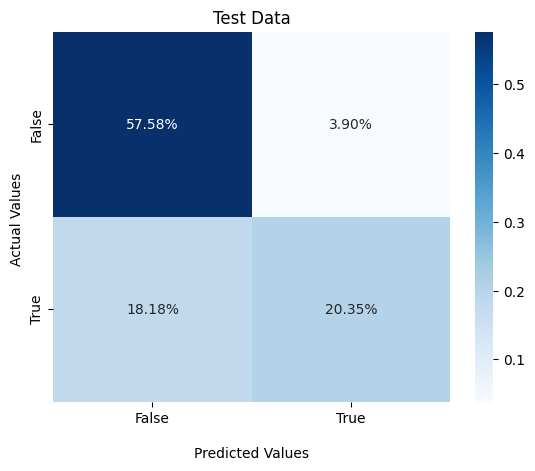

In [16]:
ax = sns.heatmap(conf_test/np.sum(conf_test), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title('Test Data');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84       142
           1       0.84      0.53      0.65        89

   micro avg       0.78      0.78      0.78       231
   macro avg       0.80      0.73      0.74       231
weighted avg       0.79      0.78      0.77       231
 samples avg       0.78      0.78      0.78       231

